In [1]:
import struct
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
def read_info(filename):
    
    info = {}

    with open(filename, "r") as file:
        for line in file:

            if "=" in line:
                key, value = line.split("=")
                key = key.strip()     # remove whitespace
                value = value.strip() # remove whitespace

                try:
                    if "." in value:
                        value = float(value)

                    else:
                        value = int(value)

                except ValueError:
                    pass # leave the value as a string

                info[key] = value
                
    return info

In [3]:
def read_header(file):
    """
    Reads a padded value from a binary file.
    Each block contains [header_size][value][tail_size].
    """
    header_size = struct.unpack('i', file.read(4))[0]
    
    if   header_size ==  4: value = struct.unpack('i', file.read(header_size))[0]
    elif header_size ==  8: value = struct.unpack('q', file.read(header_size))[0]
    elif header_size == 16: value = struct.unpack('4i', file.read(header_size))
    else:
        raise ValueError(f"Unexpected header size: {header_size} bytes")
    
    tail_size = struct.unpack('i', file.read(4))[0]
    
    if header_size != tail_size:
        raise ValueError(f"Size mismatch: header_size={header_size}, tail_size={tail_size}")
    
    return value

In [4]:
def read_data(file, npart, dtype=np.float64):
    header_size = struct.unpack('i', file.read(4))[0]
    data = np.fromfile(file, dtype=dtype, count=npart)
    tail_size = struct.unpack('i', file.read(4))[0]
    
    if header_size != tail_size:
        raise ValueError(f"Size mismatch: header_size={header_size}, tail_size={tail_size}")
    
    return data

In [5]:
def get_output(filename, fields=None):
    
    data = {}

    with open(filename, 'rb') as file:
        """
        output_part.f90:
        ! Write header
          write(ilun)ncpu
          write(ilun)ndim
          write(ilun)npart #per MPI rank
          write(ilun)localseed
          write(ilun)nstar_tot #in total box
          write(ilun)mstar_tot #in total box
          write(ilun)mstar_lost
          write(ilun)nsink # bh
        """

        # Read all header values
        ncpu = read_header(file)
        ndim = read_header(file)
        npart = read_header(file)
        localseed = read_header(file)
        nstar_tot = read_header(file)
        mstar_tot = read_header(file)
        mstar_lost = read_header(file)
        nsink = read_header(file)

        # Save header information
        data['header'] = {
            'ncpu': ncpu,
            'ndim': ndim,
            'npart': npart,
            'localseed': localseed,
            'nstar_tot': nstar_tot,
            'mstar_tot': mstar_tot,
            'mstar_lost': mstar_lost,
            'nsink': nsink
        }


        # Read data
        positions = np.zeros((npart, ndim))
        positions[:, 0] = read_data(file, npart, dtype=np.float64)
        positions[:, 1] = read_data(file, npart, dtype=np.float64)
        positions[:, 2] = read_data(file, npart, dtype=np.float64)
        data['positions'] = positions

        velocities = np.zeros((npart, ndim))
        velocities[:, 0] = read_data(file, npart, dtype=np.float64)
        velocities[:, 1] = read_data(file, npart, dtype=np.float64)
        velocities[:, 2] = read_data(file, npart, dtype=np.float64)
        data['velocities'] = velocities

        data['masses']  = read_data(file, npart, dtype=np.float64)
        data['ids']     = read_data(file, npart, dtype=np.int64)
        data['levels']  = read_data(file, npart, dtype=np.int32)
        data['phi']      = read_data(file, npart, dtype=np.float64)
        data['tc_birth'] = read_data(file, npart, dtype=np.float64)
        data['metal']    = read_data(file, npart, dtype=np.float64)
        data['tp_birth'] = read_data(file, npart, dtype=np.float64)
        data['masses0']  = read_data(file, npart, dtype=np.float64)
        data['indtab']   = read_data(file, npart, dtype=np.float64)

    # If specific fields are requested, filter data
    if fields:
        filtered_data = {field: data[field] for field in fields if field in data}
        return filtered_data
    
    return data


# Load table

In [6]:
w0 = -1
wa = 0

sign_w0 = '+' if w0 >= 0 else ''
sign_wa = '+' if wa >= 0 else ''

fname_table = "/md/gilee/cosmos-in-us/Multiverse-utils/notebooks/friedmann/"
fname_table+= f"time_table_cpl{sign_w0}{w0:.1f}{sign_wa}{wa:.1f}.csv"

print(fname_table)

/md/gilee/cosmos-in-us/Multiverse-utils/notebooks/friedmann/time_table_cpl-1.0+0.0.csv


In [7]:
with open(fname_table, "r") as file:
    lines = file.readlines()
lines

['# Cosmological Table\n',
 '# w0=-1.0, wa=0.0\n',
 '# H0=72.0, Omega_m=0.26, Omega_l=0.74, Omega_k=0\n',
 '# Columns: t, tau0, tau1, a\n',
 '1e-08,1e-08,1e-08,1.0\n',
 '1.0020052006350778e-08,1.002005219956829e-08,1.0020052088178002e-08,0.9999999999799479\n',
 '1.0040144473771554e-08,1.0040144608207333e-08,1.0040144567904002e-08,0.9999999999598554\n',
 '1.006027714851071e-08,1.0060277306545179e-08,1.0060277291807674e-08,0.9999999999397228\n',
 '1.008045025950682e-08,1.0080450375371498e-08,1.0080450397133504e-08,0.9999999999195497\n',
 '1.0100663745998969e-08,1.0100663895638016e-08,1.0100663872105795e-08,0.9999999998993362\n',
 '1.0120917773720155e-08,1.0120917948458772e-08,1.0120917878541316e-08,0.9999999998790822\n',
 '1.0141212384181934e-08,1.014121261511045e-08,1.0141212535032607e-08,0.9999999998587875\n',
 '1.0161547768519637e-08,1.0161547977032736e-08,1.0161547962165991e-08,0.9999999998384521\n',
 '1.0181923925322538e-08,1.0181924115828556e-08,1.0181924080201866e-08,0.99999999981

In [8]:
table = pd.read_csv(fname_table, skiprows=4, names=['t', 'tau0', 'tau1', 'a'])
table = table.dropna()

In [9]:
table

,t,tau0,tau1,a
0,1.000000e-08,1.000000e-08,1.000000e-08,1.000000
1,1.002005e-08,1.002005e-08,1.002005e-08,1.000000
2,1.004014e-08,1.004014e-08,1.004014e-08,1.000000
3,1.006028e-08,1.006028e-08,1.006028e-08,1.000000
4,1.008045e-08,1.008045e-08,1.008045e-08,1.000000
...,...,...,...,...
9782,1.002562e+00,3.237304e+00,5.352141e+01,0.004559
9783,1.002602e+00,3.243795e+00,5.498120e+01,0.004338
9784,1.002641e+00,3.250300e+00,5.651943e+01,0.004122
9785,1.002679e+00,3.256818e+00,5.814261e+01,0.003911


# Info

In [62]:
snapNum = 150
basePath = f"/md/gilee/cosmos-in-us/Multiverse-utils/notebooks/read_particle/lmin07-lcdm-32-01-grammar/output_{snapNum:05d}"
# basePath = f"/md/gilee/cosmos-in-us/Multiverse-utils/notebooks/read_particle/lmin07-hr5-32-01-grammar/output_{snapNum:05d}"

In [63]:
info = read_info(f"{basePath}/info_{snapNum:05d}.txt")

In [64]:
info

{'ncpu': 32,
 'ndim': 3,
 'levelmin': 7,
 'levelmax': 14,
 'ngridmax': 625000,
 'nstep_coarse': 1182,
 'boxlen': 1.0,
 'time': 0.000880146924473549,
 'aexp': 1.00087458933253,
 'H0': 72.0,
 'omega_m': 0.259999990463257,
 'omega_l': 0.740000009536743,
 'omega_k': 0.0,
 'omega_b': 0.0469999983906746,
 'unit_l': 2.02027426222196e+26,
 'unit_d': 2.52730225114842e-30,
 'unit_t': 4.28526364750053e+17,
 'ordering type': 'hilbert'}

In [65]:
ncpu = info['ncpu']
ndim = info['ndim']
nstep = info['nstep_coarse']

boxlen = info['boxlen']
unit_l = info['unit_l'] # side length of a simulation box in cm
unit_d = info['unit_d'] # volume mean density in g/cm^3
unit_t = info['unit_t'] # Aexp^2 / (H0/3.08 * 10^19) ?

levelmin = info['levelmin']
levelmax = info['levelmax']

time = info['time']
aexp = info['aexp']

H0 = info['H0'] # km/s/Mpc
h = H0 / 100

# Code unit

### Time

In [66]:
Mpc_to_km = 206265 * 1.496 * 1e14
Mpc_to_cm = Mpc_to_km * 1e5

invH0_to_sec = Mpc_to_km # H0 [km/s/Mpc] --> [km/s/km] --> [1/s]
invH0_to_Gyr = invH0_to_sec / 3600 / 24 / 365 / 1e9

unit_t = 1/H0 * invH0_to_Gyr

In [67]:
Mpc_to_cm

3.0857244e+24

In [68]:
print(unit_t)

13.58995539489261


### Length

In [69]:
dx_fin_kpc = 1 # kpc

# Box size calculation
n_cell0    = 2**levelmin              # initial number of cell
c_Lbox_kpc = 2**levelmax * dx_fin_kpc # [ckpc] comoving box size
c_Lbox_Mpc = c_Lbox_kpc/1000          # [cMpc] comoving box size

In [70]:
print(levelmin)
print(c_Lbox_Mpc) # Mpc

7
16.384


In [71]:
boxlen * unit_l / Mpc_to_cm # why is it different? it should be equal to the box size

65.47163648905132

In [72]:
boxlen * unit_l / Mpc_to_cm / c_Lbox_Mpc # ~ 4 times larger

3.996071563052449

### Mass

In [96]:
Msun_to_g = 1.989e33

unit_m = unit_d * unit_l**3 / Msun_to_g # [Msun]
unit_m

1.0477396859704284e+16

# Load particle data

In [74]:
npart_tot = 0

for icpu in range(1, ncpu+1):
    filename = f"{basePath}/part_{snapNum:05d}.out{icpu:05d}"
    data = get_output(filename, fields=['header'])
    npart_tot += data['header']['npart']

print(f"{npart_tot:,.0f}")

3,277,929


How can I distinguish stellar / DM particles here?

<IPython.core.display.Javascript object>


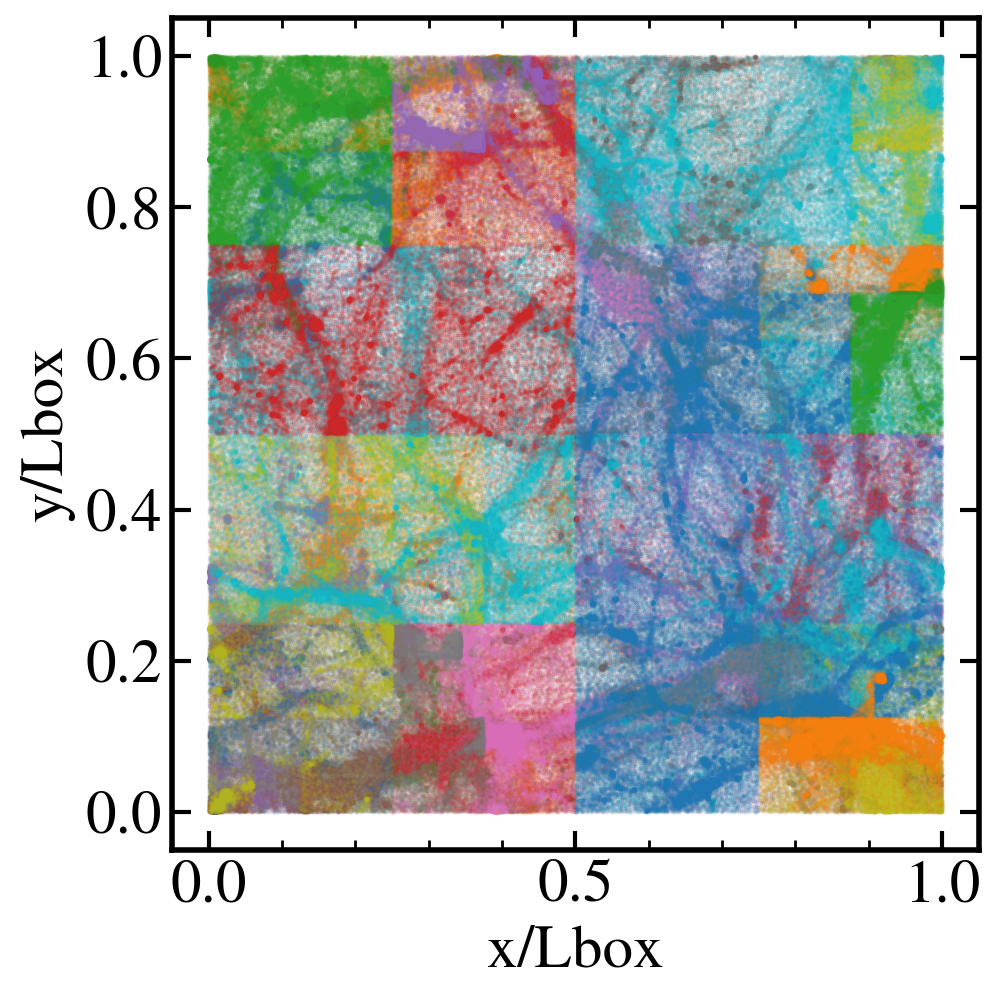

0 82431
82431 210735
210735 310865
310865 412515
412515 508882
508882 614965
614965 720688
720688 810537
810537 931135
931135 1079452
1079452 1161073
1161073 1262882
1262882 1383407
1383407 1512670
1512670 1601285
1601285 1697300
1697300 1793431
1793431 1906299
1906299 1980304
1980304 2099554
2099554 2194662
2194662 2279324
2279324 2360129
2360129 2460181
2460181 2565762
2565762 2667561
2667561 2770883
2770883 2870609
2870609 2955447
2955447 3064481
3064481 3195523
3195523 3277929


In [119]:
plt.figure(figsize=(5, 5))

pos  = np.zeros((npart_tot, ndim), dtype=np.float64)
vel  = np.zeros((npart_tot, ndim), dtype=np.float64)
npart = np.zeros(ncpu, dtype=np.int64)
masses0 = np.zeros(npart_tot, dtype=np.float64)
masses  = np.zeros(npart_tot, dtype=np.float64)
tp_birth = np.zeros(npart_tot, dtype=np.float64)
tc_birth = np.zeros(npart_tot, dtype=np.float64)

for icpu in range(ncpu):
    filename = f"{basePath}/part_{snapNum:05d}.out{icpu+1:05d}"
    data = get_output(filename)
    
    npart[icpu] = data['header']['npart']
    
    plt.scatter(data['positions'][:, 0], data['positions'][:, 1], s=0.1, alpha=0.1)
        
    i = np.sum(npart[:icpu])
    j = np.sum(npart[:icpu+1])
    print(i, j)
    
    pos[i:j, 0] = data['positions'][:, 0]
    pos[i:j, 1] = data['positions'][:, 1]
    pos[i:j, 2] = data['positions'][:, 2]
    
    vel[i:j, 0] = data['velocities'][:, 0]
    vel[i:j, 1] = data['velocities'][:, 1]
    vel[i:j, 2] = data['velocities'][:, 2]
    
    masses[i:j]  = data['masses']
    masses0[i:j] = data['masses0']
    
    tp_birth[i:j] = data['tp_birth']
    tc_birth[i:j] = data['tc_birth']

plt.xlabel("x/Lbox")
plt.ylabel("y/Lbox")
plt.tight_layout(pad=0.3)

In [120]:
np.cumsum(npart)

array([  82431,  210735,  310865,  412515,  508882,  614965,  720688,
        810537,  931135, 1079452, 1161073, 1262882, 1383407, 1512670,
       1601285, 1697300, 1793431, 1906299, 1980304, 2099554, 2194662,
       2279324, 2360129, 2460181, 2565762, 2667561, 2770883, 2870609,
       2955447, 3064481, 3195523, 3277929])

<IPython.core.display.Javascript object>


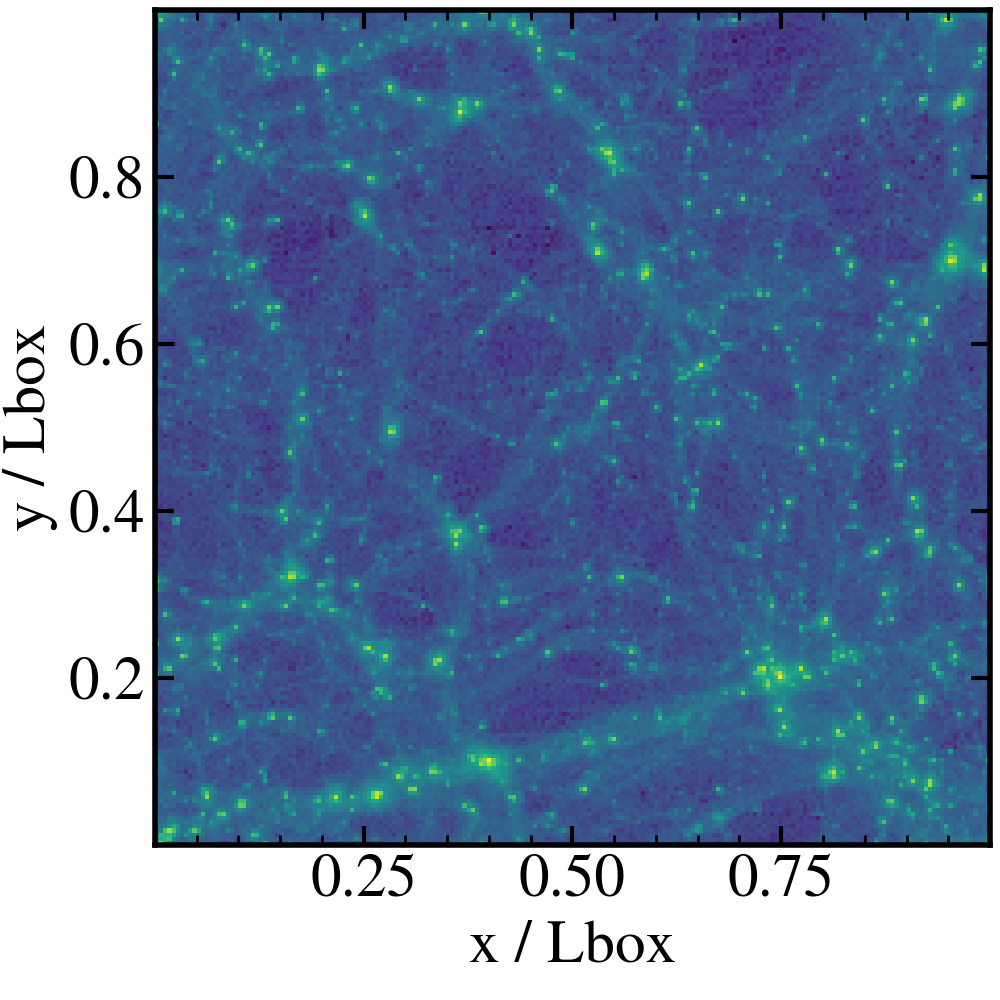

In [121]:
plt.subplots(figsize=(5, 5))
# plt.scatter(pos[:, 0], pos[:, 1], s=0.1, c='k', alpha=0.1)
plt.hist2d(pos[:, 0], pos[:, 1], norm=mpl.colors.LogNorm(), bins=201)
plt.axis('equal')
plt.xlabel("x / Lbox")
plt.ylabel("y / Lbox")
plt.subplots_adjust(bottom=0.155, left=0.155, top=0.99, right=0.99)

# Star Formation History (conformal time)

In [122]:
tc_birth.min(), tc_birth.max()

(-7.795470276340866, 0.0008801469244735492)

In [123]:
tc_birth[-tc_birth > 0].max()

-4.245463464561143e-05

In [124]:
np.where(tc_birth == 0)

(array([      0,       1,       2, ..., 3277922, 3277923, 3277927]),)

In [125]:
len(np.where(tc_birth == 0)[0]) # DM particles?

2746334

In [126]:
(2**levelmin)**3 # initial DM particle number?

2097152

<IPython.core.display.Javascript object>


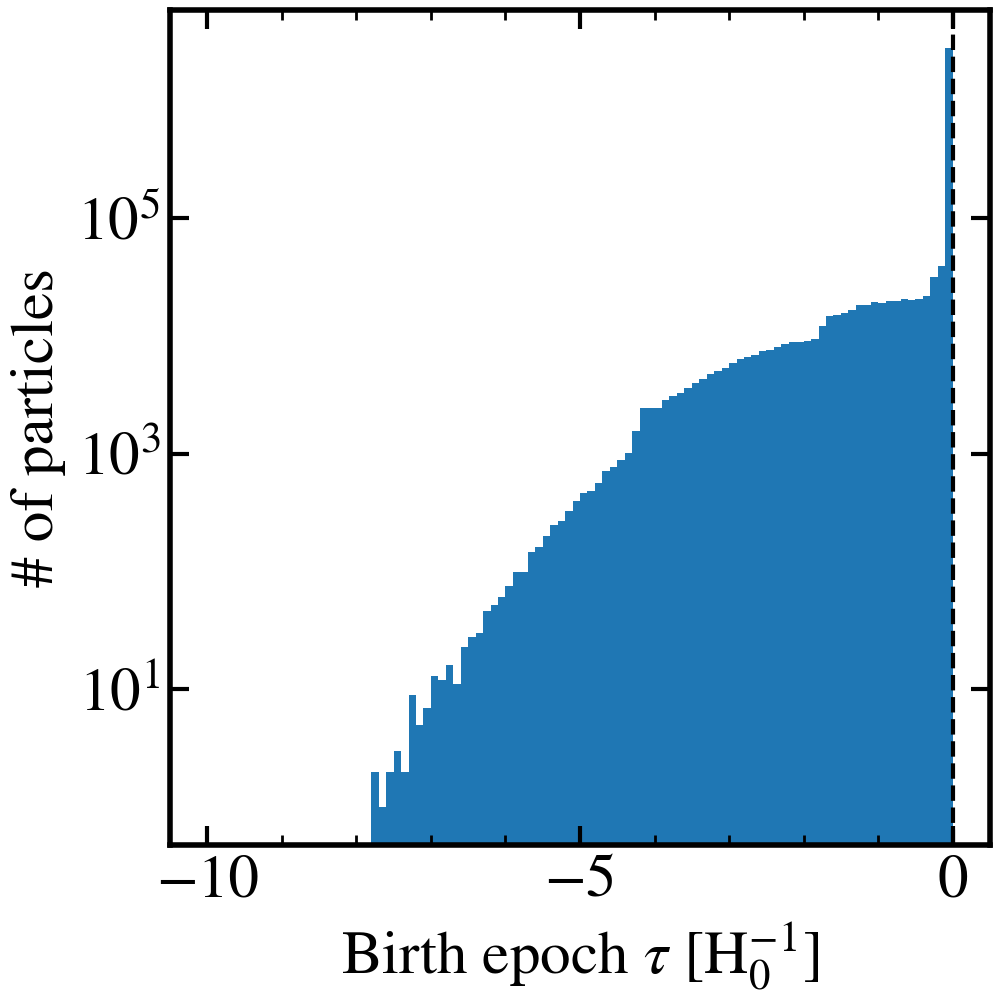

Text(0, 0.5, '# of particles')

In [127]:
plt.subplots(figsize=(5, 5))
plt.hist(tc_birth, bins=np.linspace(-10, 0, 101))
plt.axvline(info['time'], ls="--", c='k') # age of the Universe at this snapshot
plt.yscale('log')
plt.subplots_adjust(bottom=0.155, left=0.17, top=0.99, right=0.99)
plt.xlabel(r"Birth epoch $\tau$ [H$_0^{-1}$]")
plt.ylabel("# of particles")

<IPython.core.display.Javascript object>


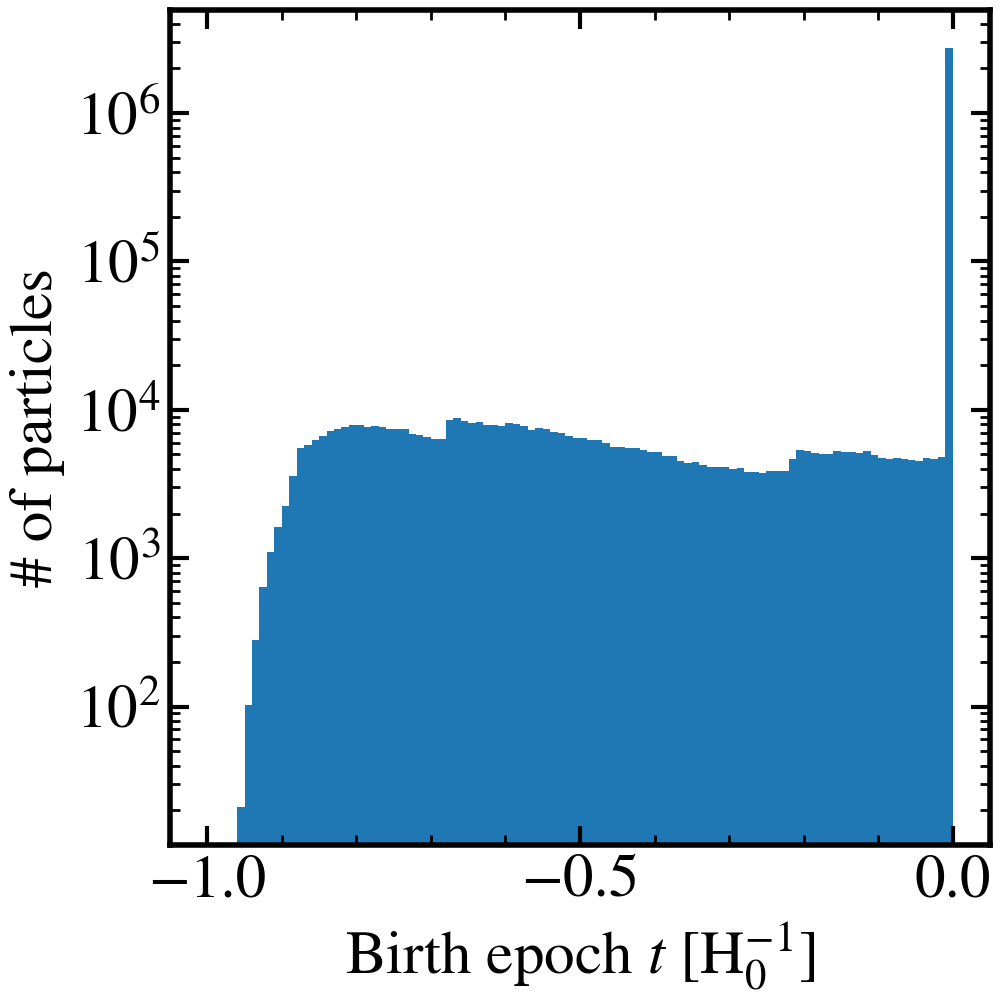

Text(0, 0.5, '# of particles')

In [128]:
plt.subplots(figsize=(5, 5))
plt.hist(tp_birth, bins=np.linspace(-1, 0, 101))
# plt.axvline(info['time'], ls="--", c='k') # age of the Universe at this snapshot
plt.yscale('log')
plt.subplots_adjust(bottom=0.155, left=0.17, top=0.99, right=0.99)
plt.xlabel(r"Birth epoch $t$ [H$_0^{-1}$]")
plt.ylabel("# of particles")

In [129]:
a_refine = np.array([0.8, 0.4, 0.2, 0.1, 0.05, 0.025, 0.0125])
z_refine = 1/a_refine - 1

In [130]:
z_refine

array([ 0.25,  1.5 ,  4.  ,  9.  , 19.  , 39.  , 79.  ])

In [131]:
np.all(np.diff(table['a']) < 0) # True: decreasing

True

In [132]:
t_refine   = np.interp(a_refine, table['a'][::-1], table['t'][::-1])
tau_refine = np.interp(a_refine, table['a'][::-1], table['tau1'][::-1])

<IPython.core.display.Javascript object>


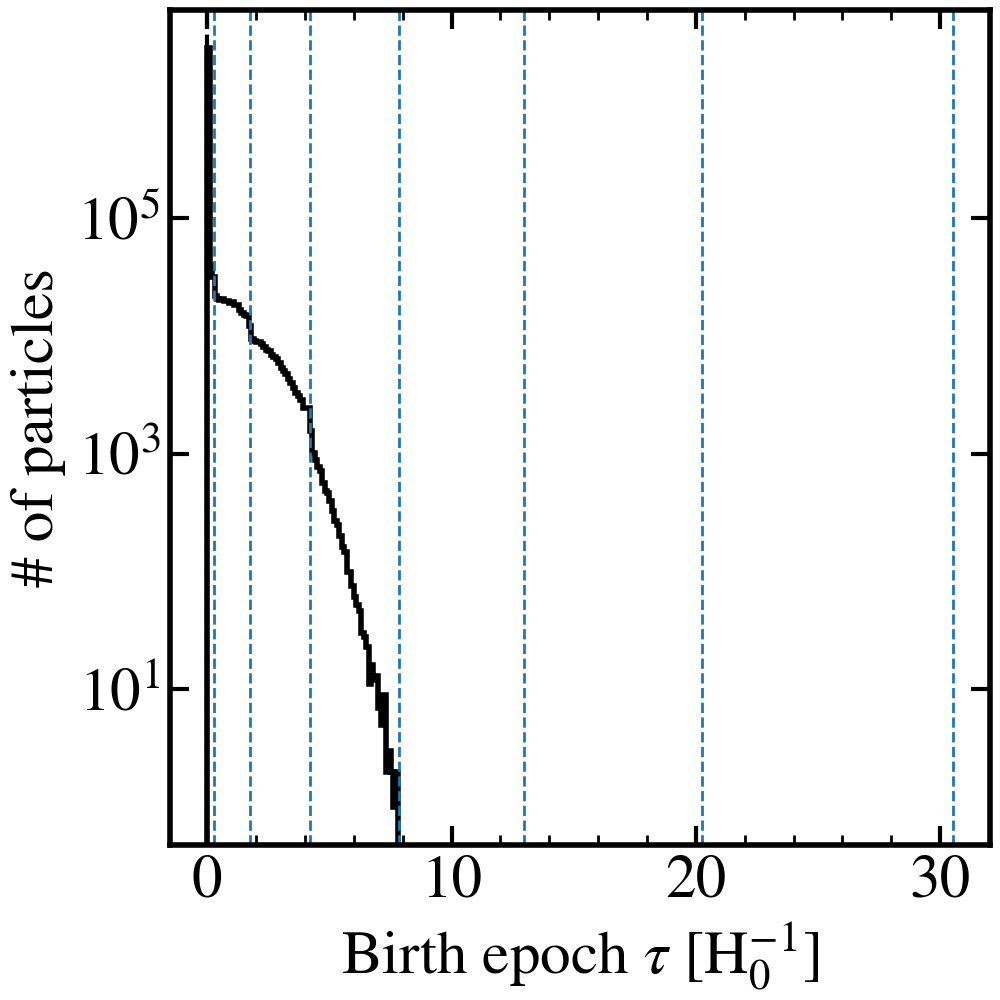

Text(0, 0.5, '# of particles')

In [133]:
plt.subplots(figsize=(5, 5))
plt.hist(-tc_birth, bins=np.linspace(0, 10, 101), histtype="step", lw=2, ec='k')
plt.axvline(info['time'], ls="--", c='k')
for tau in tau_refine:
    plt.axvline(tau, ls="--", lw=1)
plt.yscale('log')
plt.subplots_adjust(bottom=0.155, left=0.17, top=0.99, right=0.99)
plt.xlabel(r"Birth epoch $\tau$ [H$_0^{-1}$]")
plt.ylabel("# of particles")

In [134]:
info['time']

0.000880146924473549

In [135]:
len(masses), len(tp_birth)

(3277929, 3277929)

In [136]:
np.max(masses * unit_m), np.min(masses * unit_m)

(4092886869.570013, 39.12571320759205)

In [139]:
np.max(masses0 * unit_m), np.min(masses0[masses0 > 0] * unit_m)

(1264375384.128813, 180625054.87554473)

<IPython.core.display.Javascript object>


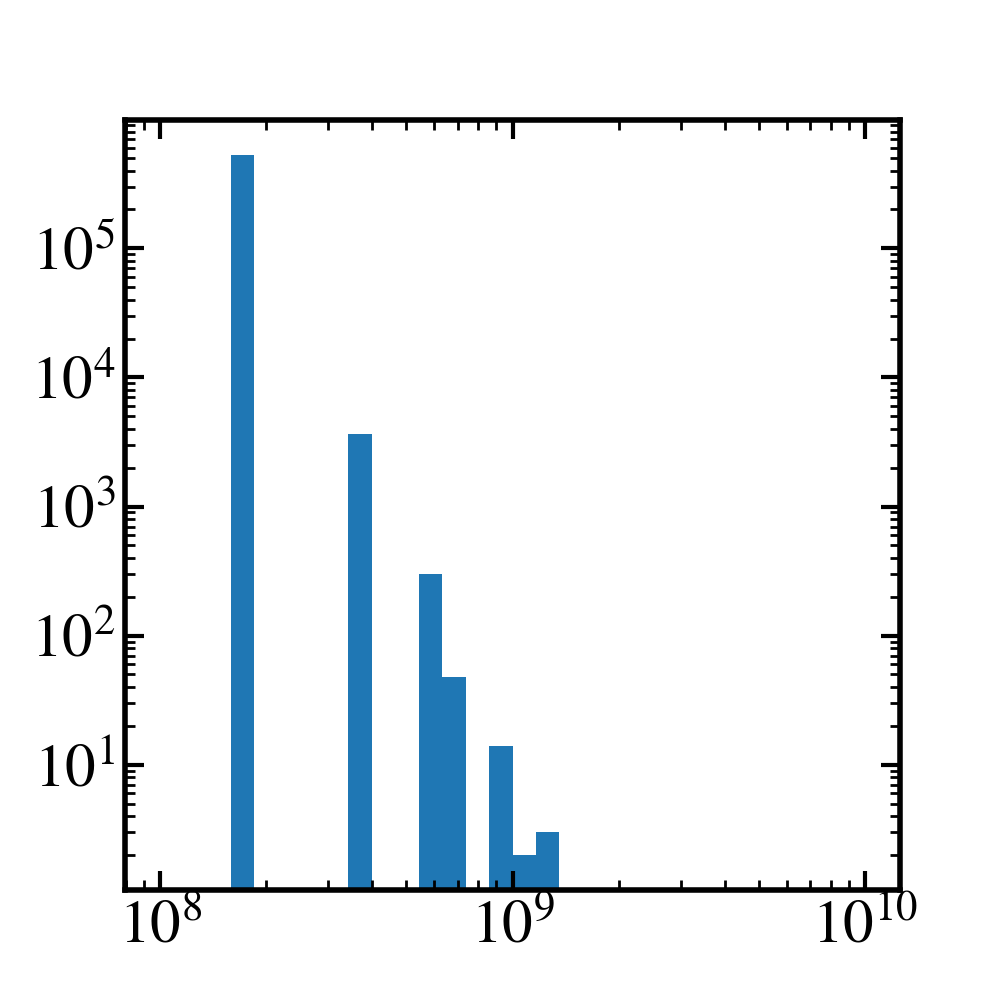

In [141]:
plt.subplots(figsize=(5, 5))
plt.hist(masses0 * unit_m, bins=np.logspace(8, 10, 31))
plt.xscale('log')
plt.yscale('log')

<IPython.core.display.Javascript object>


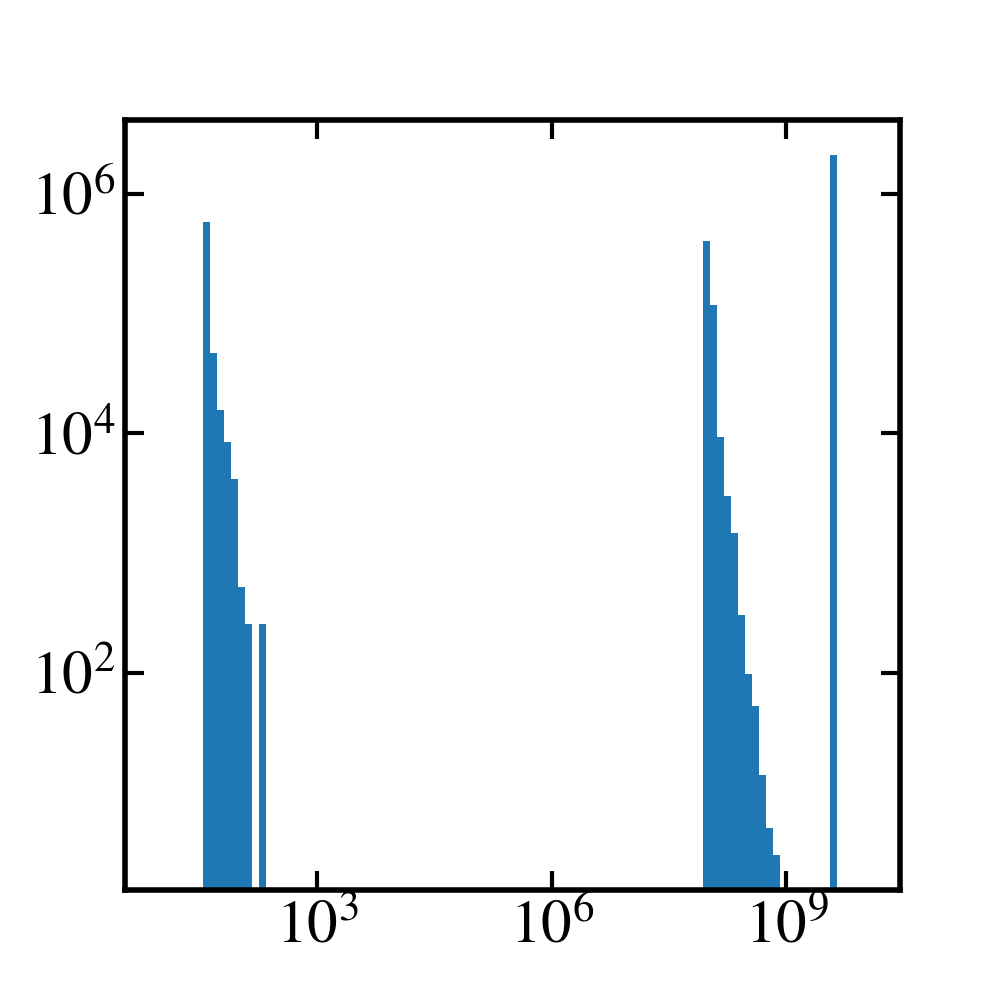

In [142]:
plt.subplots(figsize=(5, 5))
plt.hist(masses * unit_m, bins=np.logspace(1, 10, 101))
plt.xscale('log')
plt.yscale('log')

<IPython.core.display.Javascript object>


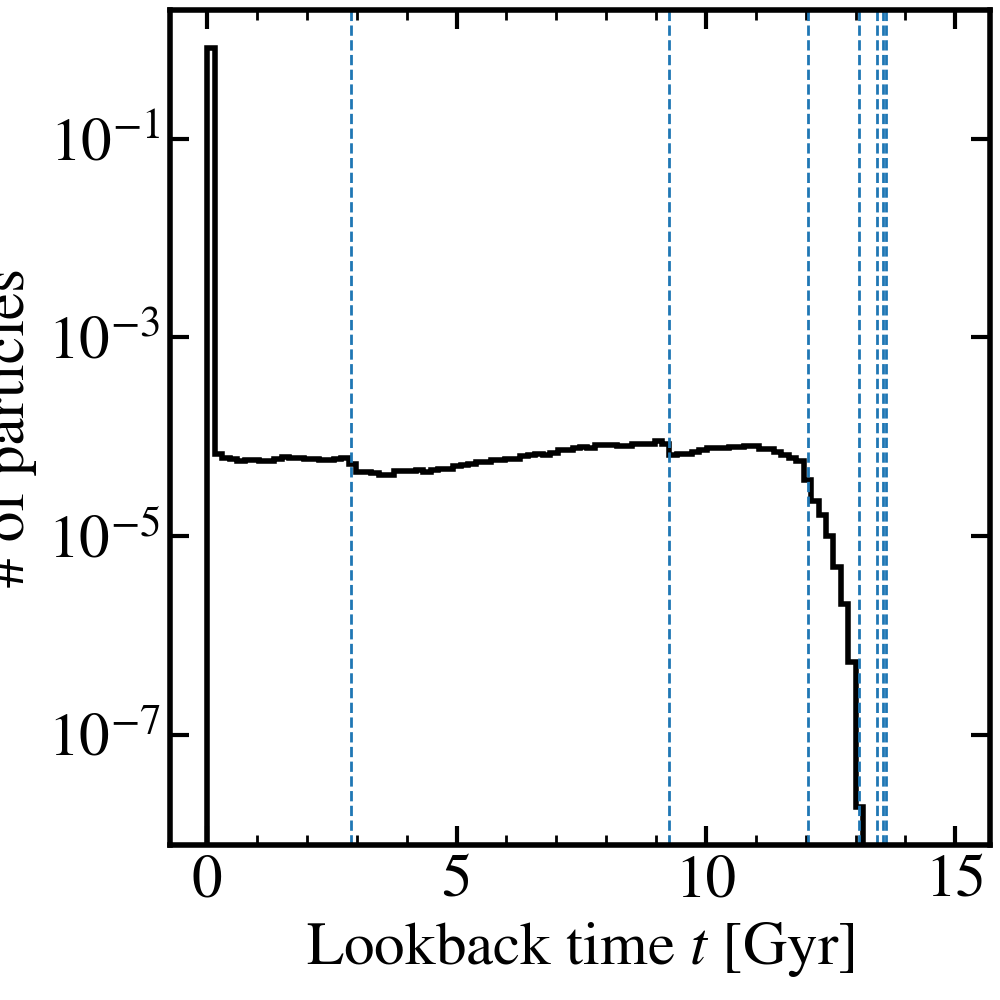

Text(0, 0.5, '# of particles')

In [149]:
plt.subplots(figsize=(5, 5))
plt.hist(-tp_birth * unit_t, bins=np.linspace(0, 1.1*unit_t, 101), weights=masses,
         histtype="step", lw=2, ec='k')
# plt.axvline(-info['time']*unit_t, ls="--", c='k')
for t in t_refine:
    plt.axvline(t*unit_t, ls="--", lw=1)
plt.yscale('log')
plt.subplots_adjust(bottom=0.155, left=0.17, top=0.99, right=0.99)
plt.xlabel(r"Lookback time $t$ [Gyr]")
plt.ylabel("# of particles")

I should match the unit of y axis to [Msun / yr / Mpc^3]

# Behroozi 2014

In [150]:
!ls /md/gilee/cosmos-in-us/Multiverse-utils/notebooks/read_particle/behroozi/behroozi-2013-data-compilation/

csfrs_new.dat  DATA_README  smf_ms  ssfr


In [151]:
basePath

'/md/gilee/cosmos-in-us/Multiverse-utils/notebooks/read_particle/lmin07-lcdm-32-01-grammar/output_00150'

In [152]:
with open(basePath+"/../../behroozi/behroozi-2013-data-compilation/csfrs_new.dat") as file:
    lines = file.readlines()
lines

['#zlow: 0.05\n',
 '#zhigh: 8.5\n',
 '#type: csfr\n',
 '2.2 -0.74416 0.19 0.19\n',
 '0.2 -1.75 0.13 0.13\n',
 '0.47 -1.62 0.13 0.13\n',
 '0.75 -1.41 0.13 0.13\n',
 '1.1 -1.25 0.17 0.17\n',
 '0.3 -1.75 0.13 0.13\n',
 '0.5 -1.63 0.13 0.13\n',
 '0.7 -1.37 0.13 0.13\n',
 '0.9 -1.33 0.17 0.17\n',
 '1.1 -1.15 0.17 0.17\n',
 '1.3 -1.05 0.17 0.17\n',
 '1.5 -0.93 0.17 0.17\n',
 '1.7 -1 0.19 0.19\n',
 '1.9 -1.05 0.19 0.19\n',
 '2.25 -1.23 0.19 0.19\n',
 '2.75 -1.23 0.19 0.19\n',
 '3.25 -1.45 0.27 0.27\n',
 '3.8 -1.95 0.27 0.27\n',
 '0.75 -1.22012189825617 0.13 0.13\n',
 '1.25 -1.15361632918473 0.17 0.17\n',
 '2 -1.02361632918473 0.19 0.19\n',
 '3 -1.0787927454597 0.27 0.27\n',
 '3.8 -1.31 0.27 0.27\n',
 '5.0 -1.71 0.27 0.27\n',
 '5.9 -1.92 0.27 0.27\n',
 '6.8 -2.14 0.27 0.27\n',
 '8.0 -2.37 0.27 0.27\n',
 '0.3 -1.72124639904717 0.13 0.13\n',
 '0.5 -1.60205999132796 0.13 0.13\n',
 '0.7 -1.36653154442041 0.13 0.13\n',
 '0.9 -1.23657200643706 0.17 0.17\n',
 '1.1 -1.13667713987954 0.17 0.17\n',
 '1.

In [153]:
behroozi = pd.read_csv(basePath+"/../../behroozi/behroozi-2013-data-compilation/csfrs_new.dat", skiprows=3, names=['z', 'log10_CSFR', 'err+', 'err-'], delim_whitespace=" ")

<IPython.core.display.Javascript object>


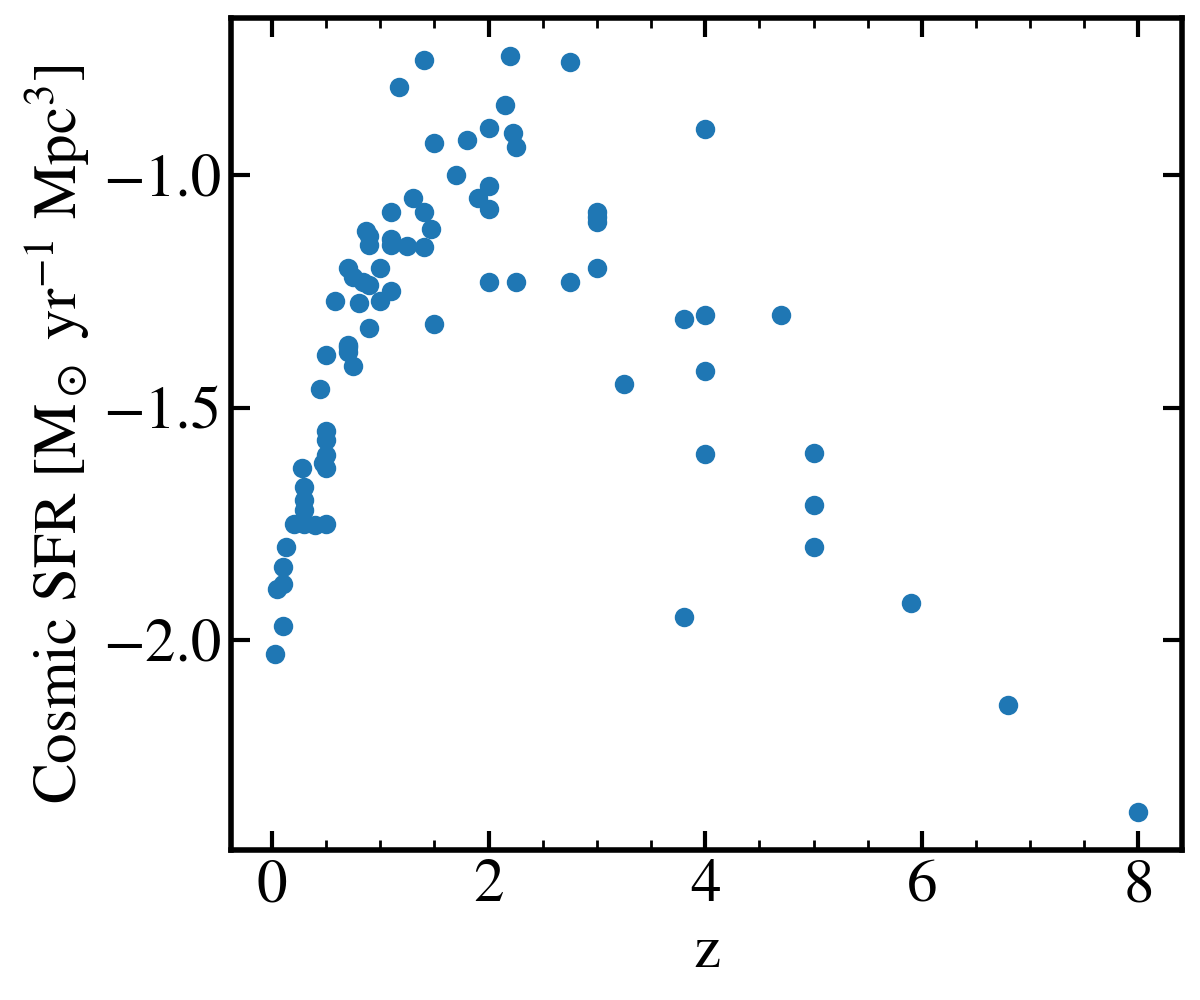

In [154]:
plt.figure(figsize=(6, 5))
plt.scatter(behroozi['z'], behroozi['log10_CSFR'])
plt.xlabel("z")
plt.ylabel(r"Cosmic SFR [M$_\odot$ yr$^{-1}$ Mpc$^{3}$]")
plt.tight_layout(pad=0.3)